In [4]:
import pandas as pd
import numpy as np
import torch.nn as nn
import sklearn
#from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
pd.set_option('display.max_columns', None)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import multiprocessing
import scipy
from sklearn.model_selection import KFold

# 读取数据

In [5]:
x_data = pd.read_excel("Shenyan_S82_ESPdescriptor+汪老师提取的所有特征-不含FE.xlsx")
x_data

c1nc[nH]n1  c1c[nH]cn1  c1cc[nH]c1  c1ccncc1  c1ccc2[nH]ccc2c1  \
0            0           0           0         0                 0   
1            0           0           0         0                 0   
2            0           0           0         0                 0   
3            0           0           0         0                 0   
4            0           0           0         0                 0   
..         ...         ...         ...       ...               ...   
77           0           0           0         0                 0   
78           0           0           0         0                 0   
79           0           0           0         0                 0   
80           0           0           0         0                 0   
81           0           0           0         0                 0   

    c1ccc2scnc2c1  c1ccc2cc3ccccc3cc2c1  c1cscn1  c1ccsc1  c1cn[nH]c1  \
0               0                     0        0        1           0   
1               0                     0        0        1           0   
2               0                     0        0        0           0   
3               0                     0        0        0           0   
4               0                     0        0        0           0   
..            ...                   ...      ...      ...         ...   
77              0                     0        0        0           0   
78              0                     0        0        0           0   
79              0                     0        0        0           0   
80              0                     0        0        0           0   
81              0                     0        0        0           0   

    c1ccc2occcc2c1  c1cc2ccc(ccnccc3ccc(ccn1)[nH]3)[nH]2  c1ccccc1  \
0                0                                     0         0   
1                0                                     0         0   
2                0                                     0         0   
3                0                                     0         0   
4                0                                     0         0   
..             ...                                   ...       ...   
77               0                                     0         0   
78               0                                     0         0   
79               0                                     0         0   
80               0                                     0         0   
81               0                                     0         0   

    c1nnn[nH]1  c1ccc2sc[n+]c2c1  c1ccc2ncccc2c1  c1nncs1  Alkene  \
0            0                 0               0        0       0   
1            0                 0               0        0       0   
2            0                 0               0        0       0   
3            0                 0               0        0       0   
4            0                 0               0        0       2   
..         ...               ...             ...      ...     ...   
77           0                 0               0        0       0   
78           0                 0               0        0       0   
79           0                 0               0        0       0   
80           0                 0               0        0       0   
81           0                 0               0        0       0   

    Alkylchloride  Alkylfluoride  Alkylbromide  Trifluoromethyl  Alcohol  \
0               0              0             0                0        0   
1               0              0             0                0        0   
2               0              0             0                0        0   
3               0              0             0                0        0   
4               0              0             0                0        0   
..            ...            ...           ...              ...      ...   
77              0              0             0                0        0   
78      

In [6]:
y_data = pd.read_csv("Target.csv", usecols=[6])
y_data

FE EtOH
0    7.587686
1   10.061535
2    6.674688
3   11.587396
4   13.044772
..        ...
77  18.137629
78  22.497833
79  17.296025
80  12.612181
81  16.436373

[82 rows x 1 columns]

In [7]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
x_data.columns = [regex.sub("_", col) if any(i in str(col) for i in set(('[', ']', '<'))) 
                        else col for col in x_data.columns.values]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.8, random_state=0)

In [8]:
scaler1 = preprocessing.MinMaxScaler().fit(x_train)  # 通过训练集获得归一化函数模型，使用 x_train 数据来计算缩放器需要的最小值和最大值
scaler2 = preprocessing.MinMaxScaler().fit(y_train)

x_train = scaler1.transform(x_train)#使用拟合好的缩放器对 x_train 数据进行缩放
x_test = scaler1.transform(x_test)

y_train = scaler2.transform(y_train)
y_test = scaler2.transform(y_test)

In [9]:
num_cores = multiprocessing.cpu_count()

In [7]:
kf = KFold(n_splits=10, random_state=0, shuffle=True) # 5折交叉验证
#mse它测量的是预测值与实际值之间差值的平方的平均值。均方误差越小，模型的预测性能越好
variate=list(range(x_train.shape[1]))   #变量索引列表
selected=[]   #变量索引
train_mse_list = []
val_mse_list = []

current_score,best_new_score=float('inf'),float('inf')  
#验证集目前的分数和最好分数初始值都为无穷大（因为mse越小越好）
    
# def my_custom_loss_func(y, y_predict):
#     error = 0
#     for i in range(0, y.shape[1]):
#         error += mean_squared_error(y[:, i], y_predict[:, i])
#     error = error / y.shape[1]
#     return error

# my_scorer = make_scorer(my_custom_loss_func, greater_is_better=False)

#循环筛选变量
while variate:
    mse_with_variate_train = []
    mse_with_variate_val=[]
    for i in variate:  #逐个遍历自变量
        current_variate = selected+[i]   #当前变量
        current_x_train = x_train[:, current_variate]   #当前x_train
        current_x_test = x_test[:, current_variate]   #当前x_test
        
        train_mse_list_ = []
        val_mse_list_ = []
        
        for train_index, val_index in kf.split(current_x_train, y_train):
            x_train_ = current_x_train[train_index, :]
            x_val_ = current_x_train[val_index, :]
            y_train_ = y_train[train_index, :]
            y_val_ = y_train[val_index, :]
            
            #model = MLPRegressor(random_state=0,early_stopping=True,alpha=0.0001,hidden_layer_sizes=(1,),learning_rate_init=0.01,
            #                    max_iter=5000,n_iter_no_change=100)
            svr = SVR(kernel='rbf')
            multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
            multioutput_svr.fit(x_train_, y_train_)
        
            train_pre = multioutput_svr.predict(x_train_)
            val_pre = multioutput_svr.predict(x_val_)
            
            train_mse_ = mean_squared_error(y_train_, train_pre)
    
            val_mse_ = mean_squared_error(y_val_, val_pre)
    
            train_mse_list_.append(train_mse_)
    
            val_mse_list_.append(val_mse_)
            
        train_mse = np.mean(train_mse_list_)
        
        val_mse = np.mean(val_mse_list_)
        
        mse_with_variate_train.append((train_mse,i))
        
        mse_with_variate_val.append((val_mse,i))
            
    min_mse_index = mse_with_variate_val.index(min(mse_with_variate_val))
    best_new_score,best_candidate_index = mse_with_variate_val[min_mse_index]
    train_new_score,_ = mse_with_variate_train[min_mse_index]
        
    variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
    selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
    
    train_mse_list.append(mse_with_variate_train[min_mse_index][0])
    
    val_mse_list.append(mse_with_variate_val[min_mse_index][0])
        
        #if current_score>best_new_score:
            #variate.remove(best_candidate_index)  #移除加进来的变量名，即第二次循环时，不考虑此自变量了
            #selected.append(best_candidate_index)  #将此自变量作为加进模型中的自变量
            #current_score = best_new_score  #最新的分数等于最好的分数
            #print("score is {},continuing!".format(current_score))  #输出最小的mse值
        #else:
            #print("for selection over!")
            #break

In [19]:
selected

[175,
 263,
 301,
 146,
 123,
 303,
 247,
 216,
 262,
 177,
 97,
 152,
 258,
 293,
 162,
 118,
 259,
 96,
 0,
 238,
 128,
 170,
 32,
 92,
 244,
 10,
 52,
 91,
 59,
 28,
 27,
 151,
 147,
 57,
 17,
 269,
 51,
 76,
 44,
 255,
 99,
 180,
 296,
 94,
 139,
 1,
 2,
 4,
 6,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 113,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 183,
 55,
 130,
 19,
 21,
 242,
 45,
 273,
 3,
 25,
 153,
 48,
 29,
 121,
 236,
 129,
 89,
 249,
 163,
 14,
 240,
 275,
 161,
 251,
 117,
 142,
 231,
 198,
 112,
 72,
 137,
 226,
 246,
 241,
 176,
 58,
 192,
 169,
 279,
 42,
 220,
 295,
 250,
 24,
 144,
 73,
 108,
 61,
 167,
 174,
 234,
 181,
 239,
 116,
 245,
 289,
 98,
 158,
 179,
 134,
 305,
 221,
 195,
 248,
 95,
 227,
 193,
 124,
 196,
 173,
 284,
 136,
 166,
 50,
 190,
 184,
 31,
 291,
 84,
 252,
 282,
 185,
 87,
 81,
 217,
 187,
 165,
 243,
 78,
 237,
 70,
 75,
 260,
 66,
 68,
 254,
 67,
 77,
 90,
 69,
 150,
 155,
 229,
 253,
 267,
 276,
 80,
 278,
 23

In [20]:
train_mse_list

[0.032067868394971236,
 0.022648279422444514,
 0.02020463376565179,
 0.01623987984747106,
 0.017122266327487926,
 0.013740747074565938,
 0.01309858707040563,
 0.01312627929122108,
 0.012474761872449057,
 0.01168754798834482,
 0.012184969012081603,
 0.011572051989623394,
 0.01094304771258824,
 0.011506193314117683,
 0.011480733312639402,
 0.011737025640067582,
 0.011727289174307813,
 0.012057748120625688,
 0.012336055728226682,
 0.012289654100264486,
 0.012315150979336758,
 0.011790181766251238,
 0.011455337730296278,
 0.011310167934020388,
 0.011414686343395158,
 0.01140505145916438,
 0.01148994188854403,
 0.011353804870682048,
 0.011455419930655962,
 0.011377620969726474,
 0.011350160986066084,
 0.01135695067241225,
 0.011350495930628372,
 0.01131645089099718,
 0.01135204692110697,
 0.011283254522766982,
 0.011343747997853386,
 0.011230203718843697,
 0.011270063378086653,
 0.011110192023478741,
 0.011161765622562308,
 0.011202287719028061,
 0.01113305541547823,
 0.011284327950307291,


In [21]:
val_mse_list

[0.037172347087494444,
 0.031340165597927835,
 0.02641891950192632,
 0.02710742015846392,
 0.026620038047732754,
 0.026036123225274765,
 0.02410207398246702,
 0.023925548092855554,
 0.024116157468629596,
 0.023606417178144837,
 0.022344809960004323,
 0.02215357601680746,
 0.02154834421533722,
 0.020943063387185552,
 0.020504973735912615,
 0.02053235516661532,
 0.020466443056548912,
 0.020585454898577778,
 0.020740981184975877,
 0.02088629617432162,
 0.020787667485296542,
 0.020651180810925603,
 0.020376987474860383,
 0.02018541124834102,
 0.019991666636183562,
 0.019907534915530996,
 0.019803792167838553,
 0.01973360812545878,
 0.01966772334316297,
 0.019592408052642833,
 0.019604113366854945,
 0.01956575135368387,
 0.019430146693943422,
 0.01937833519865859,
 0.01939786067938302,
 0.019419959488638238,
 0.01942674719758363,
 0.019461633219106156,
 0.019507250563084083,
 0.019528190672802516,
 0.019572297394994942,
 0.01962578484279174,
 0.019674655822431907,
 0.01967124435847344,
 0.0

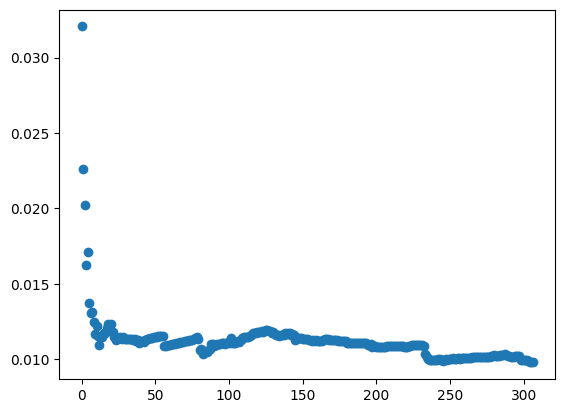

In [22]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

plt.scatter(range(len(train_mse_list)), train_mse_list)
plt.show()

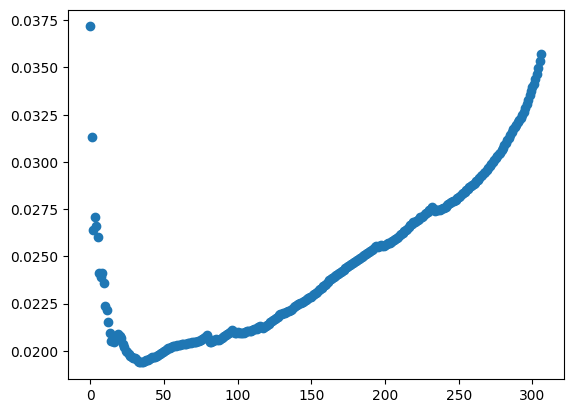

In [23]:
plt.scatter(range(len(val_mse_list)), val_mse_list)
plt.show()

In [11]:
val_mse_list = [0.037172347087494444,
 0.031340165597927835,
 0.02641891950192632,
 0.02710742015846392,
 0.026620038047732754,
 0.026036123225274765,
 0.02410207398246702,
 0.023925548092855554,
 0.024116157468629596,
 0.023606417178144837,
 0.022344809960004323,
 0.02215357601680746,
 0.02154834421533722,
 0.020943063387185552,
 0.020504973735912615,
 0.02053235516661532,
 0.020466443056548912,
 0.020585454898577778,
 0.020740981184975877,
 0.02088629617432162,
 0.020787667485296542,
 0.020651180810925603,
 0.020376987474860383,
 0.02018541124834102,
 0.019991666636183562,
 0.019907534915530996,
 0.019803792167838553,
 0.01973360812545878,
 0.01966772334316297,
 0.019592408052642833,
 0.019604113366854945,
 0.01956575135368387,
 0.019430146693943422,
 0.01937833519865859,
 0.01939786067938302,
 0.019419959488638238,
 0.01942674719758363,
 0.019461633219106156,
 0.019507250563084083,
 0.019528190672802516,
 0.019572297394994942,
 0.01962578484279174,
 0.019674655822431907,
 0.01967124435847344,
 0.019688854652952184,
 0.019733062932350092,
 0.019794112082555278,
 0.019833599195663503,
 0.019886282432978512,
 0.01993061036651734,
 0.01998249083343586,
 0.020042572797601986,
 0.02008838975740033,
 0.02012573799681123,
 0.020165679354381683,
 0.02020845460341837,
 0.020239903372462873,
 0.020261002403241128,
 0.020265343622021238,
 0.020285578152386054,
 0.020304441807223038,
 0.020311388091357446,
 0.02033284897730455,
 0.02033743166999432,
 0.02034725943069932,
 0.02037623651841632,
 0.020390357701022085,
 0.020408053640212177,
 0.020427407158958764,
 0.020436548807558328,
 0.020453344199191363,
 0.020470247285611927,
 0.020470437751572673,
 0.020506183494703796,
 0.020534981348078078,
 0.020567195496036236,
 0.020610899097087736,
 0.020671570548657744,
 0.02073916688188691,
 0.020848868119936602,
 0.020662635238745574,
 0.02048213215118949,
 0.020487567070467894,
 0.020534374604360354,
 0.020573272679286717,
 0.020621351281319093,
 0.0205604160185057,
 0.02058914477002092,
 0.020620982034262023,
 0.02065414762436259,
 0.020707061023515973,
 0.02076412092637365,
 0.02082370743402815,
 0.020880973320334197,
 0.020938932711410743,
 0.021000412909328747,
 0.021075936578417876,
 0.021031696745176277,
 0.02094822673029511,
 0.020940886594389037,
 0.02098869297794874,
 0.020943246559035244,
 0.02094228891864704,
 0.02095841171764568,
 0.02094861364353393,
 0.020983056897442443,
 0.021020269850791255,
 0.021030090305041625,
 0.021069015437249324,
 0.021069298491132083,
 0.021089952442834577,
 0.021128395401195873,
 0.021138786693777813,
 0.021176403480598304,
 0.021240949151293514,
 0.021295800609653824,
 0.021247429141207853,
 0.021215624108699878,
 0.021263364855697863,
 0.021328739882736085,
 0.021386047804865915,
 0.021436400631918557,
 0.021501596431395296,
 0.021572130044540838,
 0.021628392310689463,
 0.021687105036175318,
 0.021738039613058265,
 0.02180514516995421,
 0.021873892779557765,
 0.021928600338887824,
 0.021967397949878124,
 0.022021602913304333,
 0.02200835746115899,
 0.022037211118293744,
 0.02208075582267237,
 0.022108497540604465,
 0.022166528457204484,
 0.022219689129155347,
 0.022295591420951506,
 0.02234683767650229,
 0.022421378250894783,
 0.022498676579885645,
 0.022554294226311493,
 0.022506868739841673,
 0.022564771820632254,
 0.022631779689491517,
 0.022678456350229567,
 0.022717400571335915,
 0.022767975983513666,
 0.02282589269389039,
 0.0228689428035502,
 0.022941971273328515,
 0.023006892557851797,
 0.02306608991883349,
 0.02312160249515385,
 0.023190322778948814,
 0.023263068225294628,
 0.023328269390112247,
 0.023415907419351435,
 0.023483513866043835,
 0.023559707421388458,
 0.02363857753499877,
 0.023720363506281397,
 0.023786962294584296,
 0.023856496343802998,
 0.023896488054273145,
 0.023938933412803003,
 0.02399344615256844,
 0.02405076879574418,
 0.024120871915545287,
 0.024180534271672865,
 0.02424036324591551,
 0.024300597059846354,
 0.024368767284114804,
 0.024432686148836313,
 0.02449085524373079,
 0.0245528814338639,
 0.02458760480365149,
 0.024665620076101458,
 0.024719084241351337,
 0.02476949654807881,
 0.024818229997389193,
 0.024863888698793423,
 0.02490549276394559,
 0.02496084204033925,
 0.025012538313542658,
 0.025073383854361038,
 0.025127686969386935,
 0.02517884338991829,
 0.025237795177526345,
 0.025289626773126433,
 0.025347576751370633,
 0.025412648391155607,
 0.02547744688850353,
 0.02553300061518988,
 0.02551158738218463,
 0.02555336609077759,
 0.025612373062183995,
 0.02556734671669077,
 0.025552535435078953,
 0.02560023396662465,
 0.025647239502650344,
 0.025685684713551815,
 0.025720971806462888,
 0.02576144063680303,
 0.025817610360563615,
 0.025873379733350688,
 0.02591779946995972,
 0.02598201393365504,
 0.026046142023963343,
 0.0261108308462741,
 0.026180815624671748,
 0.026259504955805164,
 0.026334213212474512,
 0.026405172570046126,
 0.026466563225650015,
 0.02656101543041393,
 0.02663253391221788,
 0.026720910307754954,
 0.026802764307280576,
 0.02684318570705486,
 0.026885998461911687,
 0.0269434897601386,
 0.026992451410248215,
 0.0270567990917359,
 0.027104641847880574,
 0.027161267489458747,
 0.02723547492277259,
 0.027294532006179,
 0.027367225133793287,
 0.027437263183008494,
 0.027506150959860663,
 0.02759004232983333,
 0.027508792449257975,
 0.027399610301143972,
 0.02744092700997778,
 0.02746120061766199,
 0.02746389438408308,
 0.02749561418502197,
 0.02753391691042644,
 0.027577070101986005,
 0.027632367633209982,
 0.02769501073457069,
 0.027747602141689393,
 0.02780292802643473,
 0.027862355234473203,
 0.027920227018930203,
 0.027940900364801846,
 0.02799532813418195,
 0.028071435929382493,
 0.028136622204486733,
 0.028215730189649367,
 0.02828789470559228,
 0.028345584500223998,
 0.028416942076523843,
 0.028496259287681486,
 0.0285813306629851,
 0.028649754041288583,
 0.02873275859555528,
 0.02879351344774463,
 0.028838698828864966,
 0.028901682926662103,
 0.02898554768422031,
 0.029058367909906374,
 0.029140066766659443,
 0.02923046080395082,
 0.029307122712647377,
 0.0293996963987826,
 0.02946596037244496,
 0.029571583276661144,
 0.029667303532197896,
 0.029763514754406566,
 0.029884143181734407,
 0.029991081090875272,
 0.030088790288850135,
 0.030188589750943885,
 0.030291803539709304,
 0.0303963379185417,
 0.030495917168647923,
 0.030632348046296776,
 0.0307461118806514,
 0.030872440900453924,
 0.031013264847256923,
 0.031145670902458837,
 0.03127252650038352,
 0.03142291270152161,
 0.031577491697935924,
 0.03171702742554482,
 0.03186640728151461,
 0.031980953062573925,
 0.03210336506503191,
 0.03221833658233725,
 0.032335652228438774,
 0.03248109265004466,
 0.032664065067373876,
 0.03285728713181268,
 0.033082829673938226,
 0.033286892603471015,
 0.03352977388523445,
 0.03378104108201821,
 0.03397381655847296,
 0.03414500054266931,
 0.0343921142698582,
 0.03465667982407731,
 0.03498765287739267,
 0.03533305266454069,
 0.03569844198531449]

min_index  = val_mse_list.index(min(val_mse_list))
min_value = val_mse_list[min_index]
print(min_index)
print(min_value)

33
0.01937833519865859


In [12]:
selected = [175,
 263,
 301,
 146,
 123,
 303,
 247,
 216,
 262,
 177,
 97,
 152,
 258,
 293,
 162,
 118,
 259,
 96,
 0,
 238,
 128,
 170,
 32,
 92,
 244,
 10,
 52,
 91,
 59,
 28,
 27,
 151,
 147,
 57,
 17,
 269,
 51,
 76,
 44,
 255,
 99,
 180,
 296,
 94,
 139,
 1,
 2,
 4,
 6,
 9,
 11,
 13,
 15,
 16,
 18,
 20,
 113,
 26,
 33,
 35,
 36,
 37,
 39,
 40,
 41,
 43,
 47,
 53,
 56,
 60,
 62,
 110,
 183,
 55,
 130,
 19,
 21,
 242,
 45,
 273,
 3,
 25,
 153,
 48,
 29,
 121,
 236,
 129,
 89,
 249,
 163,
 14,
 240,
 275,
 161,
 251,
 117,
 142,
 231,
 198,
 112,
 72,
 137,
 226,
 246,
 241,
 176,
 58,
 192,
 169,
 279,
 42,
 220,
 295,
 250,
 24,
 144,
 73,
 108,
 61,
 167,
 174,
 234,
 181,
 239,
 116,
 245,
 289,
 98,
 158,
 179,
 134,
 305,
 221,
 195,
 248,
 95,
 227,
 193,
 124,
 196,
 173,
 284,
 136,
 166,
 50,
 190,
 184,
 31,
 291,
 84,
 252,
 282,
 185,
 87,
 81,
 217,
 187,
 165,
 243,
 78,
 237,
 70,
 75,
 260,
 66,
 68,
 254,
 67,
 77,
 90,
 69,
 150,
 155,
 229,
 253,
 267,
 276,
 80,
 278,
 232,
 138,
 148,
 126,
 93,
 79,
 235,
 257,
 186,
 277,
 168,
 82,
 182,
 125,
 111,
 302,
 101,
 65,
 285,
 63,
 86,
 46,
 286,
 64,
 141,
 256,
 189,
 304,
 71,
 131,
 83,
 201,
 74,
 22,
 23,
 300,
 218,
 268,
 299,
 223,
 34,
 127,
 194,
 208,
 197,
 200,
 191,
 209,
 215,
 206,
 5,
 202,
 54,
 306,
 30,
 7,
 107,
 271,
 102,
 8,
 160,
 199,
 210,
 203,
 145,
 233,
 49,
 204,
 290,
 298,
 274,
 222,
 272,
 224,
 213,
 100,
 159,
 115,
 119,
 132,
 85,
 135,
 188,
 261,
 297,
 280,
 122,
 212,
 230,
 207,
 288,
 228,
 225,
 266,
 172,
 88,
 211,
 265,
 292,
 294,
 120,
 140,
 219,
 143,
 287,
 205,
 214,
 281,
 12,
 157,
 156,
 104,
 103,
 283,
 171,
 106,
 149,
 105,
 178,
 38,
 164,
 154,
 109,
 264,
 133,
 114,
 270]

#for i in selected[:18]:
    #j = sorted_index[i]
    #print('{}'.format(x_train.columns[i]))

In [13]:
selected_columns = x_data.columns[selected[:min_index+1]].tolist()
for col in selected_columns:
    print(col)

Conju-Part-Wt (Max-Conju)
Long/Sum Size Ratio
Atom1_ESP Maximal value (kcal/mol)
VSA_EState7
SlogP_VSA4
Atom1_ESP Pi (kcal/mol)
Conju_LogP_Min
Mid-Fun_PEOE-Charge_Sum
Molecular Size Long
Max Conju-Distance (Max-Conju)
PEOE_VSA12
NOCount
Farthest Distance
ALIE Minimal Value
NumRotatableBonds
SlogP_VSA10
Molecular Radius
PEOE_VSA11
c1nc_nH_n1
Conju_LogP_Mean
TPSA
Num of Conju-All-Atoms
Disulfide
Kappa3
Conju_LogP_Max
c1ccc2occcc2c1
Arylbromide
Kappa2
Sulfonic_derivative
Secondary_arom_amine
Primary_arom_amine
NHOHCount
VSA_EState8
Nitro


In [38]:
#col_index = [sorted_index[i] for i in selected[:min_index+1]]
# 指定图像保存的路径
import os
save_dir = '逐步回归S-体系挑选变量\用师兄的特征 and 汪老师的特征'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
data = x_data[selected_columns]
# 将选定的数据保存为 CSV 文件
output_file = os.path.join(save_dir, "selected_features-EtOH.csv")
data.to_csv(output_file, index=False, encoding='utf_8_sig')
data

Conju-Part-Wt (Max-Conju)  Long/Sum Size Ratio  \
0                     108.121             0.491618   
1                     160.015             0.449793   
2                      44.009             0.399801   
3                      44.009             0.483168   
4                      24.022             0.527381   
..                        ...                  ...   
77                      0.000             0.660614   
78                      0.000             0.625620   
79                      0.000             0.569067   
80                      0.000             0.530080   
81                      0.000             0.463316   

    Atom1_ESP Maximal value (kcal/mol)  VSA_EState7  SlogP_VSA4  \
0                            90.133446     0.000000         0.0   
1                            69.205496     0.000000         0.0   
2                            74.758819     0.000000         0.0   
3                            78.529901     0.259401         0.0   
4                            31.069320     3.793981         0.0   
..                                 ...          ...         ...   
77                           42.573869    10.967467         0.0   
78                           43.318557     8.044435         0.0   
79                           45.745684     3.764228         0.0   
80                           48.501562     2.402006         0.0   
81                           57.972576     0.000000         0.0   

    Atom1_ESP Pi (kcal/mol)  Conju_LogP_Min  Mid-Fun_PEOE-Charge_Sum  \
0                 13.207422          0.6122             7.436550e-01   
1                 12.774025          2.5106            -4.160000e-17   
2                 14.830128         -0.4222            -1.879163e-01   
3                 15.026383         -0.4222            -4.545539e-01   
4                 14.378481          0.6792            -3.857851e-02   
..                      ...             ...                      ...   
77                13.985197          0.0000            -1.543219e-01   
78                14.029267          0.0000            -1.543219e-01   
79                14.192581          0.0000            -1.543219e-01   
80                14.306475          0.0000            -1.543209e-01   
81                14.944512          0.0000            -1.525587e-01   

    Molecular Size Long  Max Conju-Distance (Max-Conju)  PEOE_VSA12  NOCount  \
0                10.674                               4         0.0        3   
1                 8.372                               3         0.0        0   
2                 7.242                               2         0.0        2   
3                12.214                               2         0.0        4   
4                11.566                               1         0.0        0   
..                  ...                             ...         ...      ...   
77               18.445                               0         0.0        0   
78               15.882                               0         0.0        0   
79               12.050                               0         0.0        0   
80               10.732                               0         0.0        0   
81                8.102                               0         0.0        0   

    Farthest Distance  ALIE Minimal Value  NumRotatableBonds  SlogP_VSA10  \
0               8.294             9.85838                  2          0.0   
1               5.355             9.73413                  0          0.0   
2               4.083             8.76834                  1          0.0   
3               9.190             8.50923                  7          0.0   
4               9.166             7.85309                  4          0.0   
..                ...                 ...                ...          ...   
77             15.453             8.02673                  9          0.0   
78             12.895             8.02737                  7          0.0   
79              9.099          

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
# 用选出来的最佳变量在测试集上进行评估
min_val_mse_index=min_index
final_x_train = x_train[:, selected[:min_val_mse_index+1]]
final_x_test = x_test[:, selected[:min_val_mse_index+1]]

svr = SVR(kernel='rbf')
multioutput_svr = MultiOutputRegressor(svr, n_jobs=-1)
multioutput_svr.fit(final_x_train, y_train)

test_pred = multioutput_svr.predict(final_x_test)
test_mse = mean_squared_error(y_test, test_pred)
test_r2 = r2_score(y_test, test_pred)
# 保留两位小数
test_mse = round(test_mse, 4)
test_r2 = round(test_r2, 4)

print(f"Selected variables based on validation MSE: {selected_columns}")
print(f"Test MSE: {test_mse}")
print(f"Test R2: {test_r2}")
# 创建保存目录
import os
save_dir = 'Test mse after svr'
os.makedirs(save_dir, exist_ok=True)  # 创建目录，如果目录不存在
output_file1 = os.path.join(save_dir, "final_evaluation-EtOH.csv")
# 保存测试集评估结果到CSV
df_summary = pd.DataFrame({
    'Selected Variables': [selected_columns],
    'Final Test MSE': [test_mse],
    'Final Test R2': [test_r2]
})
df_summary.to_csv(output_file1, index=False)

print(f"Results saved to '{output_file1}'")

Selected variables based on validation MSE: ['Conju-Part-Wt (Max-Conju)', 'Long/Sum Size Ratio', 'Atom1_ESP Maximal value (kcal/mol)', 'VSA_EState7', 'SlogP_VSA4', 'Atom1_ESP Pi (kcal/mol)', 'Conju_LogP_Min', 'Mid-Fun_PEOE-Charge_Sum', 'Molecular Size Long', 'Max Conju-Distance (Max-Conju)', 'PEOE_VSA12', 'NOCount', 'Farthest Distance', 'ALIE Minimal Value', 'NumRotatableBonds', 'SlogP_VSA10', 'Molecular Radius', 'PEOE_VSA11', 'c1nc_nH_n1', 'Conju_LogP_Mean', 'TPSA', 'Num of Conju-All-Atoms', 'Disulfide', 'Kappa3', 'Conju_LogP_Max', 'c1ccc2occcc2c1', 'Arylbromide', 'Kappa2', 'Sulfonic_derivative', 'Secondary_arom_amine', 'Primary_arom_amine', 'NHOHCount', 'VSA_EState8', 'Nitro']
Test MSE: 0.0549
Test R2: -0.0652
Results saved to 'Test mse after svr/final_evaluation-EtOH.csv'
